In [1]:
# Settings for notebook
try:
    import scrapy
except:
    !pip install scrapy
    import scrapy
try:
    import pandas as pd
except:
    !pip install pandas
    import pandas as pd

from scrapy.crawler import CrawlerProcess
from scrapy.linkextractors import LinkExtractor
from scrapy.spiders import CrawlSpider,Rule
from scrapy.exceptions import IgnoreRequest
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from urllib.parse import urlparse
import urllib.request

import unicodedata
import logging
import sys
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import json
import numpy as np

In [2]:
class JsonWriterPipeline(object):
    def open_spider(self, spider):
        print('json opened')
        self.file = open('tripAdvisor_result_white_rock_lake.j1', 'w')

    def close_spider(self, spider):
        print('json closed')
        self.file.close()

    def process_item(self, item, spider):
        line = json.dumps(dict(item)) + "\n"
        self.file.write(line)
        return item

In [3]:
class tripAdvisorSpider(CrawlSpider):
    ###################INPUT PARAMETERS######################
    count_MAX = 100
    # I am using the stop words collection from NLTK package
    stop_words = list(set(stopwords.words('english'))) 
    #########################################################
    name = 'tripAdvisor_spider'
    allowed_domains = ['www.tripadvisor.com']
    start_urls = ['https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-White_Rock_Lake_Park-Dallas_Texas.html']
    download_delay = 5.0
    httpcache_enabled = True
    count = 0
    handle_httpstatus_list = [404] 
    content_seen = {}
    custom_settings = {
        'LOG_LEVEL': logging.WARNING,
        'ITEM_PIPELINES': {'__main__.JsonWriterPipeline': 1}, # Used for pipeline 1
        'FEED_FORMAT':'json',                                 # Used for pipeline 2
        'FEED_URI': 'tripAdvisor_result_white_rock_lake.json',                        # Used for pipeline 2
        'ROBOTSTXT_ENABLED':True,
        'ROBOTSTXT_OBEY': True,                                 # obey robots.txt rule
                        }
    def __init__(self):
        self.driver = webdriver.Firefox()         
    def parse(self,response):
        def strip_not_start_with_alphabets(string):
            str_list = string.split()
            new_string=[]
            for i in str_list:
                if i[0].isalpha():
                    new_string.append(i)    
            return ' '.join(new_string)
        def strip_stop_words(string,stop_words):
            for stop_word in stop_words:
                string = string.replace(' '+stop_word+' ',' ')
            return string
        def strip_single_letter(string):
            str_list = string.split()
            new_string=[]
            for i in str_list:
                if len(i)>1:
                    new_string.append(i)
            return ' '.join(new_string)    
        def strip_punctuation(string):
            x = ''.join(string.replace(',',''))
            x = x.replace("'",'')
            x = x.replace('"','')
            x = x.replace(':',' ')
            x = x.replace(';',' ')
            x = x.replace('!',' ')
            x = x.replace('(',' ')
            x = x.replace(')',' ')
            x = x.replace('.',' ')
            x = x.replace('-',' ')
            x = x.replace('/',' ')
            x = x.replace('@',' ')
            x = ' '.join(x.split())
            return x
        def text_processing(response):
            try:
                html = urllib.request.urlopen(response.url).read()  
                soup = BeautifulSoup(html, 'lxml')
                for tag in soup.find_all(['script', 'style','head', 'title']):
                    tag.decompose() 
                text = ' '.join(soup.findAll(text=True))
                #text= soup.getText(strip=False)
            except:
                text=response.xpath('(//text())').extract()
            #################### Text Processing########################
            # 1) remove non-breaking space e.g:\xa0,  
            text = unicodedata.normalize("NFKD",''.join(text))
            # 2) remove \n\r\t
            text = text.replace('\n'," ").replace('\r'," ").replace('\t'," ")
            # 3) lowercase all letters
            text = text.lower()
            # 4) remove stop words
            text = strip_stop_words(text,self.stop_words)
            # 5) remove extra spaces
            text = " ".join(text.split())
            # 6) remove special characters
            text = strip_punctuation(text)
            # 7) remove single letter
            text = strip_single_letter(text)
            # 8) remove any non-space strings that start with non-alphabets
            text = strip_not_start_with_alphabets(text)
            return text
            ############################################################
        if (self.count <self.count_MAX):
            print(100*'-')
            print('retrieve count: ',self.count,' => ',response.url)
            self.count = self.count + 1
            # Expand all 'show more' buttons
            self.driver.get(response.url)
            self.driver.find_element_by_css_selector("span.taLnk.ulBlueLinks").click()
            self.driver.wait = WebDriverWait(self.driver, 5)
            REVIEW_SELECTOR = '.review-container'
            for reviewset in response.css(REVIEW_SELECTOR):
                REVIEW_ID = reviewset.css('::attr(data-reviewid)').extract_first()
                FULL_REVIEW = self.driver.find_element_by_id("review_"+REVIEW_ID)
                ENTRY = FULL_REVIEW.find_element_by_class_name("partial_entry")
                QUOTE_SELECTOR = '.noQuotes ::text'
                # photo tag
                PHOTO_CONTAINER = '.inlinePhotosWrapper'
                if reviewset.css(PHOTO_CONTAINER):
                    src_url = reviewset.css('.inlinePhotosWrapper ::attr(src)').extract()
                    img_url = []
                    for lk in src_url:
                        if urlparse(lk)[0]=='https':
                            img_url.append(lk.replace('photo-l','photo-w').replace('photo-f','photo-w')) # if photo-w doesn't work, try photo-s
                    print(img_url)
                    photos = img_url
                else:
                    photos = 'None'
                yield {
                'title': reviewset.css(QUOTE_SELECTOR).extract_first(),
                'review': ENTRY.text,
                'photo': photos,
            }
            NEXT_OFFSET_SELECTOR = 'a.nav.next.taLnk.ui_button.primary ::attr(data-offset)' 
            next_offset = response.css(NEXT_OFFSET_SELECTOR).extract_first()
            if next_offset:
                r = self.start_urls[0].split('Reviews')
                next_page = ''.join([r[0],'Reviews-or',str(next_offset),r[1]])
                print('next page: ',next_page)
                yield scrapy.Request(next_page, callback = self.parse)
                
        else:
            scrapy.exceptions.CloseSpider('Retrieve page limit reached')

In [4]:
def run_crawler():
    import os
    if os.path.isfile('tripAdvisor_result_white_rock_lake.json'):
        os.remove('tripAdvisor_result_white_rock_lake.json')
    if os.path.isfile('tripAdvisor_result_white_rock_lake.j1'):
        os.remove('tripAdvisor_result_white_rock_lake.j1')
    process = CrawlerProcess({
        'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'
    })
    process.crawl(tripAdvisorSpider)
    process.start()
run_crawler()

2018-04-11 23:30:09 [scrapy.utils.log] INFO: Scrapy 1.5.0 started (bot: scrapybot)
2018-04-11 23:30:09 [scrapy.utils.log] INFO: Versions: lxml 3.7.3.0, libxml2 2.9.4, cssselect 1.0.3, parsel 1.4.0, w3lib 1.19.0, Twisted 17.9.0, Python 3.6.1 |Anaconda custom (x86_64)| (default, May 11 2017, 13:04:09) - [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)], pyOpenSSL 17.0.0 (OpenSSL 1.0.2l  25 May 2017), cryptography 1.8.1, Platform Darwin-15.6.0-x86_64-i386-64bit
2018-04-11 23:30:09 [scrapy.crawler] INFO: Overridden settings: {'FEED_FORMAT': 'json', 'FEED_URI': 'tripAdvisor_result_white_rock_lake.json', 'LOG_LEVEL': 30, 'ROBOTSTXT_OBEY': True, 'USER_AGENT': 'Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1)'}


json opened
----------------------------------------------------------------------------------------------------
retrieve count:  0  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-White_Rock_Lake_Park-Dallas_Texas.html
['https://media-cdn.tripadvisor.com/media/photo-w/12/74/c3/12/sunset-at-lake.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/12/74/c2/f2/kayaking-the-white-rock.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/12/74/c3/03/marina-by-sunset.jpg']
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or10-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  1  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or10-White_Rock_Lake_Park-Dallas_Texas.html
['https://media-cdn.tripadvisor.com/media/photo-w/11/ee/ca/87/the-sun-sets-over-downtown.jpg']
next page:  https://www.tripadvisor.com

next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or150-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  15  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or150-White_Rock_Lake_Park-Dallas_Texas.html
['https://media-cdn.tripadvisor.com/media/photo-w/0a/9c/16/6b/enjoyed-seeing-the-sunset.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/0a/9c/16/36/enjoyed-seeing-the-sunset.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/0a/9c/16/5e/enjoyed-seeing-the-sunset.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/0a/9c/16/26/enjoyed-seeing-the-sunset.jpg']
['https://media-cdn.tripadvisor.com/media/photo-w/0a/8a/f1/4e/20160309-104820-largejpg.jpg', 'https://media-cdn.tripadvisor.com/media/photo-w/0a/8a/f1/4d/20160309-104904-largejpg.jpg']
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Rev

----------------------------------------------------------------------------------------------------
retrieve count:  30  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or300-White_Rock_Lake_Park-Dallas_Texas.html
['https://media-cdn.tripadvisor.com/media/photo-w/06/8b/45/25/white-rock-lake-park.jpg']
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or310-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  31  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or310-White_Rock_Lake_Park-Dallas_Texas.html
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or320-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  32  =>  https://www.tripadvisor.com/Attraction_Review-g55711-

next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or500-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  50  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or500-White_Rock_Lake_Park-Dallas_Texas.html
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or510-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  51  =>  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or510-White_Rock_Lake_Park-Dallas_Texas.html
next page:  https://www.tripadvisor.com/Attraction_Review-g55711-d139514-Reviews-or520-White_Rock_Lake_Park-Dallas_Texas.html
----------------------------------------------------------------------------------------------------
retrieve count:  52  =>  https://www.trip

In [2]:
df_raw = pd.read_json('tripAdvisor_result.json')
df_imgurl = df_raw[['photo']]
df = df_raw[['review']]
df

,review
0,This is a beautiful lake. They have lots of tr...
1,I've probably lost count of the number of even...
2,One of my favorite places in Dallas. Great bik...
3,The area must be visited..that is for sure..bu...
4,Very nice lake ! Great place to ride a bike or...
5,There are hiking and biking trails around the ...
6,Enjoy this park. There is a 9 mile path circli...
7,I can't count the number of times that I have ...
8,A fun place to walk run or bike around the lak...
9,We've been here many times. A great spot for a...


In [3]:
row_todrop = []
for row in df_imgurl.index:
    if df_imgurl['photo'][row]=='None':
        row_todrop.append(row)

In [4]:
df_imgurl = df_imgurl.drop(row_todrop)
df_imgurl['photo'][1]

['https://media-cdn.tripadvisor.com/media/photo-f/12/74/c3/12/sunset-at-lake.jpg',
 'https://media-cdn.tripadvisor.com/media/photo-w/12/74/c2/f2/kayaking-the-white-rock.jpg',
 'https://media-cdn.tripadvisor.com/media/photo-f/12/74/c3/03/marina-by-sunset.jpg']

In [5]:
df_img = pd.DataFrame(columns=['img'])
img = []
for i in df_imgurl.index:
    for j in df_imgurl.loc[i,'photo']:
        img.append(j)
for item in list(set(img)):
    df_img = df_img.append({'img':item},ignore_index=True)

In [6]:
# for idx in df_img.index:
#     print(idx,': ',df_img.loc[idx,'img'])

In [7]:
for idx in df_img.index:
    try:
        urllib.request.urlopen(df_img.loc[idx,'img'])
    except:
        df_img.loc[idx,'img'] = df_img.loc[idx,'img'].replace('photo-w','photo-s')
#         print(idx,': ', df_img.loc[idx,'img'])

1 :  https://media-cdn.tripadvisor.com/media/photo-s/10/8e/6e/3c/on-the-east-side-of-the.jpg
8 :  https://media-cdn.tripadvisor.com/media/photo-s/04/7f/ac/e3/white-rock-lake-park.jpg
9 :  https://media-cdn.tripadvisor.com/media/photo-s/02/cc/fe/1e/white-rock-lake-park.jpg
11 :  https://media-cdn.tripadvisor.com/media/photo-s/02/35/83/c7/playing-in-the-park.jpg
14 :  https://media-cdn.tripadvisor.com/media/photo-s/02/cc/fe/38/white-rock-lake-park.jpg
16 :  https://media-cdn.tripadvisor.com/media/photo-s/06/b2/13/41/ducks.jpg
23 :  https://media-cdn.tripadvisor.com/media/photo-s/06/e6/d0/d3/white-rock-lake-park.jpg
24 :  https://media-cdn.tripadvisor.com/media/photo-s/01/1c/df/dd/dallas.jpg
27 :  https://media-cdn.tripadvisor.com/media/photo-s/06/b2/13/3c/sunset-at-the-white-rock.jpg
29 :  https://media-cdn.tripadvisor.com/media/photo-s/03/15/da/3c/white-rock-lake-park.jpg
45 :  https://media-cdn.tripadvisor.com/media/photo-s/10/8e/6e/28/the-boat-dock-not-many.jpg
51 :  https://media-cdn

In [81]:
for idx in df_img.index:
    print(idx,': ',df_img.loc[idx,'img'])

0 :  https://media-cdn.tripadvisor.com/media/photo-w/0d/14/f9/e3/photo0jpg.jpg
1 :  https://media-cdn.tripadvisor.com/media/photo-s/0b/ba/2a/d6/white-rock-lake-park.jpg
2 :  https://media-cdn.tripadvisor.com/media/photo-w/10/95/f3/70/photo5jpg.jpg
3 :  https://media-cdn.tripadvisor.com/media/photo-w/06/1d/f2/f5/white-rock-lake-park.jpg
4 :  https://media-cdn.tripadvisor.com/media/photo-w/06/b2/13/3d/birds-of-the-same-feather.jpg
5 :  https://media-cdn.tripadvisor.com/media/photo-s/02/cc/fe/38/white-rock-lake-park.jpg
6 :  https://media-cdn.tripadvisor.com/media/photo-w/10/95/f3/6f/photo4jpg.jpg
7 :  https://media-cdn.tripadvisor.com/media/photo-w/0a/cb/83/8f/photo0jpg.jpg
8 :  https://media-cdn.tripadvisor.com/media/photo-s/03/15/da/3c/white-rock-lake-park.jpg
9 :  https://media-cdn.tripadvisor.com/media/photo-w/09/76/97/08/white-rock-lake-park.jpg
10 :  https://media-cdn.tripadvisor.com/media/photo-w/10/0a/e8/62/white-rock-lake-park.jpg
11 :  https://media-cdn.tripadvisor.com/media/ph

### Using Microsoft computer vision API to describe images

In [129]:
import requests
def TagsFromImageUrl(image_url):
    tags=[]
    subscription_key ='ad2363f4a4de49ef9312bf957e3d85cc'
    # image_url = 'https://media-cdn.tripadvisor.com/media/photo-s/02/15/17/ea/white-rock-lake-park.jpg'
    vision_base_url = "https://westcentralus.api.cognitive.microsoft.com/vision/v1.0/"
    vision_analyze_url = vision_base_url + "analyze"
    headers  = {'Ocp-Apim-Subscription-Key': subscription_key }
    params   = {'visualFeatures': 'Categories,Description,Color,Tags'}
    data     = {'url': image_url}
    response = requests.post(vision_analyze_url, headers=headers, params=params, json=data)
    response.raise_for_status()
    analysis = response.json()
    for item in analysis['tags']:
        if item['confidence']>0.85:
            tags.append((item['name'],item['confidence']))
    return tags
# image_caption = analysis["description"]["captions"][0]["text"].capitalize()

In [128]:
analysis

{'categories': [{'detail': {'landmarks': []},
   'name': 'outdoor_',
   'score': 0.015625},
  {'detail': {'landmarks': []},
   'name': 'outdoor_waterside',
   'score': 0.80859375}],
 'color': {'accentColor': '346197',
  'dominantColorBackground': 'Grey',
  'dominantColorForeground': 'Grey',
  'dominantColors': ['Grey'],
  'isBwImg': False},
 'description': {'captions': [{'confidence': 0.9172233074164096,
    'text': 'a park bench next to a body of water'}],
  'tags': ['grass',
   'outdoor',
   'bench',
   'park',
   'water',
   'lake',
   'river',
   'sitting',
   'body',
   'pond',
   'path',
   'side',
   'green',
   'large',
   'wooden',
   'tree',
   'grassy',
   'field']},
 'metadata': {'format': 'Jpeg', 'height': 366, 'width': 550},
 'requestId': '938eb891-d5c0-4d30-9041-f671c12ee343',
 'tags': [{'confidence': 0.9999972581863403, 'name': 'grass'},
  {'confidence': 0.9999523162841797, 'name': 'outdoor'},
  {'confidence': 0.999873161315918, 'name': 'tree'},
  {'confidence': 0.98930

In [108]:
tags = TagsFromImageUrl(df_img.loc[idx,'img'])

In [131]:
import time
print(df_img.shape[0],' images to be processed')
for idx in df_img.index:
    tags = TagsFromImageUrl(df_img.loc[idx,'img'])
    tag_text = ''
    for word,name in tags:
        tag_text = ' '.join([tag_text,word])
    df_img.loc[idx,'tags'] = tag_text
    print(idx,': ',df_img.loc[idx,'img'])
    print(df_img.loc[idx,'tags'])
    time.sleep(5)

89  images to be processed
0 :  https://media-cdn.tripadvisor.com/media/photo-w/0d/14/f9/e3/photo0jpg.jpg
 outdoor tree grass
1 :  https://media-cdn.tripadvisor.com/media/photo-s/0b/ba/2a/d6/white-rock-lake-park.jpg
 water outdoor sky
2 :  https://media-cdn.tripadvisor.com/media/photo-w/10/95/f3/70/photo5jpg.jpg
 grass tree outdoor field
3 :  https://media-cdn.tripadvisor.com/media/photo-w/06/1d/f2/f5/white-rock-lake-park.jpg
 outdoor water sky
4 :  https://media-cdn.tripadvisor.com/media/photo-w/06/b2/13/3d/birds-of-the-same-feather.jpg
 grass tree outdoor sky
5 :  https://media-cdn.tripadvisor.com/media/photo-s/02/cc/fe/38/white-rock-lake-park.jpg
 sky outdoor water
6 :  https://media-cdn.tripadvisor.com/media/photo-w/10/95/f3/6f/photo4jpg.jpg
 grass tree outdoor field
7 :  https://media-cdn.tripadvisor.com/media/photo-w/0a/cb/83/8f/photo0jpg.jpg
 grass outdoor sky water tree river building
8 :  https://media-cdn.tripadvisor.com/media/photo-s/03/15/da/3c/white-rock-lake-park.jpg
 tre

72 :  https://media-cdn.tripadvisor.com/media/photo-w/06/9d/7b/27/white-rock-lake-park.jpg
 text book
73 :  https://media-cdn.tripadvisor.com/media/photo-f/06/8b/45/25/white-rock-lake-park.jpg
 sky nature water outdoor
74 :  https://media-cdn.tripadvisor.com/media/photo-w/09/ef/63/03/photo0jpg.jpg
 outdoor sky sunset grass
75 :  https://media-cdn.tripadvisor.com/media/photo-s/04/7f/ac/e3/white-rock-lake-park.jpg
 grass outdoor sky tree
76 :  https://media-cdn.tripadvisor.com/media/photo-w/0f/e4/ba/77/white-rock-lake-park.jpg
 tree outdoor grass sky
77 :  https://media-cdn.tripadvisor.com/media/photo-w/06/9d/7b/38/white-rock-lake-park.jpg
 outdoor water tree sky lake sunset river
78 :  https://media-cdn.tripadvisor.com/media/photo-w/09/ef/63/04/photo1jpg.jpg
 water outdoor sky
79 :  https://media-cdn.tripadvisor.com/media/photo-w/09/76/97/05/white-rock-lake-park.jpg
 tree sky outdoor
80 :  https://media-cdn.tripadvisor.com/media/photo-s/10/8e/6e/31/on-the-east-side-of-the.jpg
 grass sky

In [132]:
df_img

,img,tags
0,https://media-cdn.tripadvisor.com/media/photo-...,outdoor tree grass
1,https://media-cdn.tripadvisor.com/media/photo-...,water outdoor sky
2,https://media-cdn.tripadvisor.com/media/photo-...,grass tree outdoor field
3,https://media-cdn.tripadvisor.com/media/photo-...,outdoor water sky
4,https://media-cdn.tripadvisor.com/media/photo-...,grass tree outdoor sky
5,https://media-cdn.tripadvisor.com/media/photo-...,sky outdoor water
6,https://media-cdn.tripadvisor.com/media/photo-...,grass tree outdoor field
7,https://media-cdn.tripadvisor.com/media/photo-...,grass outdoor sky water tree river building
8,https://media-cdn.tripadvisor.com/media/photo-...,tree outdoor animal sky bird sitting branch p...
9,https://media-cdn.tripadvisor.com/media/photo-...,water sky outdoor lake tree river


    Text processing

In [7]:
from textblob import TextBlob

In [8]:
tknz = TweetTokenizer()
df_tokenize = df.applymap(lambda x: tknz.tokenize(x) )

In [9]:
def remove_stopwords(list_words):
    new_list = []
    for word in list_words:
        if word not in list(set(stopwords.words('english'))):
            new_list.append(word)
    return new_list
def lower_case(list_words):
    return [word.lower() for word in list_words]

In [10]:
df_lowercase = df_tokenize.applymap(lambda x: lower_case(x))

In [11]:
%%time
df_remove_stopwords = df_lowercase.applymap(lambda x: remove_stopwords(x) )

CPU times: user 13.4 s, sys: 1.6 s, total: 15 s
Wall time: 15.9 s


In [13]:
def stemming(list_words):
    new_list = []
    return new_list

In [12]:
from textblob import Word
from nltk import pos_tag
def lemmatization(list_words):
    #lemma does not accept pos tags natively - convert to simplified version
    posTb2Wn={'JJ':'a', 'JJR':'a', 'JJS':'a', 'RB':'r', 'RBR':'r', 'RBS':'r', 'VB':'v', 'VBD':'v', 
              'VBG':'v', 'VBN':'v', 'VBP':'v', 'VBZ':'v', 'NN':'n', 'NNS':'n', 'NNP':'n', 'NNPS':'n', 
              'n':'n', 'a':'a', 'r':'r', 'v':'v', 's':'s'}
    return [Word(word).lemmatize(posTb2Wn.get(tag)) for word,tag in pos_tag(list_words)]

In [326]:
%%time
df_lemma = df_remove_stopwords.applymap(lambda x: lemmatization(x) )
df_lemma2 = df_lowercase.applymap(lambda x: lemmatization(x) )

CPU times: user 7.83 s, sys: 219 ms, total: 8.05 s
Wall time: 8.32 s


In [327]:
df_review = df.copy()
df_review['lower_case'] = df_lowercase.loc[:,'review'].apply(lambda x: ' '.join(x))
df_review['lemmatization'] = df_lemma2.loc[:,'review'].apply(lambda x: ' '.join(x))
df_review['review_clean'] = df_lemma.loc[:,'review'].apply(lambda x: ' '.join(x))

In [200]:
df_review.head()

,review,lower_case,review_clean
0,This is a beautiful lake. They have lots of tr...,this is a beautiful lake . they have lots of t...,"beautiful lake . lot trail walk , also wonderf..."
1,I've probably lost count of the number of even...,i've probably lost count of the number of even...,i've probably lose count number evening & week...
2,One of my favorite places in Dallas. Great bik...,one of my favorite places in dallas . great bi...,"one favorite place dallas . great biking , cyc..."
3,The area must be visited..that is for sure..bu...,the area must be visited .. that is for sure ....,area must visit .. sure .. .. say .. grow teen...
4,Very nice lake ! Great place to ride a bike or...,very nice lake ! great place to ride a bike or...,nice lake ! great place ride bike take walk de...


In [154]:
zen = TextBlob(df_review['review_clean'][0])
print(zen.sentences[0])
s=zen.sentences[0]

beautiful lake .


In [328]:
%%time
from nltk.util import ngrams
from collections import Counter
df_features = pd.DataFrame(columns = ['nouns'])
n=1
f1 = open('sentences.basket','w')
f2 = open('features.basket','w')
for idx in df_review.index:
    zen = TextBlob(df_review.loc[idx,'review_clean'])
    for sentence in zen.sentences:
        # write raw sentences to file
        f1.write(str(sentence)+'\n')
        tags = sentence.tags
        feature_set = []
        noun_words = []
        for word,tag in tags:
            if tag in ['NN', 'NNS', 'NNP', 'NNPS'] :
                noun_words.append(word)
        if len(noun_words)>0:
            f2.write(','.join(noun_words)+'\n')
#                 feature_set.append(word)
#         df_features = df_features.append({'nouns': feature_set}, ignore_index=True)
#         df_features.loc[n,'nouns'] = feature_set
#         n=n+1
f1.close()
f2.close()

CPU times: user 2.7 s, sys: 61 ms, total: 2.76 s
Wall time: 2.84 s


In [35]:
import Orange
from orangecontrib.associate.fpgrowth import *

In [254]:
data = Orange.data.Table("features.basket")
X, mapping = OneHot.encode(data, include_class=False)
coded_names = {item: '{}'.format(var.name)
          for item, var, val in OneHot.decode(mapping, data, mapping)}

In [132]:
itemsets = dict(frequent_itemsets(X, .01))

In [260]:
itemsets = dict(frequent_itemsets(X, .01))
f3 = open('frequent features.txt','w')
n=0
frequent_features={}
for itemset in itemsets:
    idx = list(itemset)
    words = []
    for i in idx:
        words.append(coded_names[i])
    frequent_features[n] = words
    n+=1
    print(' '.join(words))
    f3.write(','.join(words)+'\n');
    
f3.close()

lake
park
lake park
place
lake place
dallas
lake dallas
park dallas
dallas place
walk
lake walk
walk place
bike
lake bike
bike walk
bike place
trail
lake trail
bike trail
trail park
rock
lake rock
rock park
lake rock park
rock dallas
lake rock dallas
area
park area
time
lake time
dog
dog park
water
people
park people
city
day
lot
lot park
mile
lake mile
path
visit
view
ride
bike ride
picnic
spot
family
run
weekend
boat
enjoy
way
watch
bird
kayak
year
/
arboretum
side
biking
fun
activity
house
runner
road
jog
drive
relax
walker
rent
hour
home
bikers
get
use
bicycle
part
cyclist
play
hike
walking
i
location
car
kid
afternoon
sailboat
see
nature
sit
friend
outdoors
canoe
playground
duck


In [356]:
def get_positioinal_index(wordlist,sentence):
    dict_posi = {}
    for word in wordlist:
         dict_posi[word] = [i for i, item in enumerate(sentence) if item == word]
    return dict_posi
def isCompact(wordlist,positional_index):
    if len(wordlist)==2:
        index1 = positional_index[wordlist[0]]
        index2 = positional_index[wordlist[1]]
        return any((id1+1 in index2)|(id1-1 in index2) for id1 in index1)
    else:
        return True
def CompactPosition(wordlist,positional_index):
    if len(wordlist)==2:
        index1 = positional_index[wordlist[0]]
        index2 = positional_index[wordlist[1]]
        for id1 in index1:
            if (id1+1 in index2):
                return [id1]
            elif (id1-1 in index2):
                return [id1-1]
    elif len(wordlist)==1:
        return positional_index[wordlist[0]]
def get_frequent_feature_occurrence(df,frequent_phrase):
    frequent_pharse_occurrence =0
    for idx in df_review.index:
        zen = TextBlob(df.loc[idx,'lemmatization'])
        for sentence in zen.sentences[0:5]:
            if len(frequent_phrase) ==2:
                if all(word in str(sentence) for word in frequent_phrase):
                    positional_index = get_positioinal_index(frequent_phrase,sentence.words)
                    if isCompact(frequent_phrase,positional_index):
#                         print('Compact: '+ str(sentence))
                        frequent_pharse_occurrence +=1
    return frequent_pharse_occurrence

In [330]:
frequent_f = ['lake','park']
for idx in range(0,50):#df_review.index:
    zen = TextBlob(df_review.loc[idx,'lemmatization'])
    for sentence in zen.sentences[0:5]:
        if len(frequent_f) ==2:
            if all(word in str(sentence) for word in frequent_f):
                print(sentence)
                positional_index = get_positioinal_index(frequent_f,sentence.words)
                print(positional_index)
                print(isCompact(frequent_f,positional_index))

do you know that german pow work to improve the lake and park ?
{'lake': [10], 'park': [12]}
False
nice and peaceful park / lake in the city .
{'lake': [4], 'park': [3]}
True
on a sunny afternoon we visit the lake and park , manage to see lot of wildlife , cyclist and runner as well a walker like u we very much enjoy the piece and quiet the lake and park offer
{'lake': [7, 34], 'park': [9, 36]}
False
the dallas white rock lake and park be a true gem in city .
{'lake': [4], 'park': [6]}
False
also lot of huge house on the west side of the lake and a dog park on the north side along mockingbird lane .
{'lake': [11], 'park': [15]}
False
take a drive around the lake and stop at the many park area to relax and watch the duck and sailboat , take a hiking trail and see nature up close , ride a bike on the many trail or just put on your running shoe and jog .
{'lake': [5], 'park': [11]}
False
we be former dallas resident and be thrill to see how much white rock lake have be improve and to see 

In [340]:
frequent_f = ['walk','bike']
frequent_pharse_occurence =0
for idx in df_review.index:
    zen = TextBlob(df_review.loc[idx,'lemmatization'])
    for sentence in zen.sentences:
        if len(frequent_f) ==2:
            if all(word in sentence.words for word in frequent_f):
                positional_index = get_positioinal_index(frequent_f,sentence.words)
                if isCompact(frequent_f,positional_index):
                    print(sentence)
                    frequent_pharse_occurence +=1
print(frequent_pharse_occurence)

plenty of pave trail suitable to walk , bike rid , jogging , and dog walking .
serene large lake view , drive along or walk / bike path .
it be prime for walk , bike riding , and below the dam be a great nature area to see bird and wildlife .
there be a 9 mile run / walk / bike trail around the lake .
it be a lake where you can bike , walk , have a picnic ... or just drive around .
it's well connect to other trail , but you can completely circle it via bike / walk / run , on the inside path or outside street ... roughly 10-11 mile a lap .
whether rid your bike , walk , run or stroll with your family , this lake be great for people watch , enjoy a picnic or kayaking , this be the spot !
run , bike , walk , swim , paddle , sit , barbecue , and relax in this great recreational spot .
the walk / bike path continue around this lake in the center of dallas offer wonderful view of this lake .
a great place to go for a walk , run , ride a bike , walk your dog , row your boat , or take your fam

In [332]:
compact_features = {}
n = 0
f4 = open('compact_features.txt','w')
for item in range(0,len(frequent_features)):
    frequent_pharse = frequent_features[item]
    if len(frequent_pharse)<2:
        compact_features[n] = frequent_pharse
        n+=1
        f4.write(frequent_pharse[0]+'\n')
    elif len(frequent_pharse)==2:
        frequent_pharse_occurrence = get_frequent_feature_occurrence(df_review,frequent_pharse)
        if frequent_pharse_occurrence>=2:
            compact_features[n] = frequent_pharse
            n+=1
            f4.write(','.join(frequent_pharse)+'\n')
            print(','.join(frequent_pharse) + ' compact features')
#         else:
#             print(','.join(frequent_pharse) + ' NOT compact features')
f4.close()
    

lake,park compact features
bike,walk compact features
lake,trail compact features
bike,trail compact features
lake,rock compact features
rock,park compact features
park,area compact features
dog,park compact features
lot,park compact features
bike,ride compact features


In [257]:
compact_features

{0: ['lake'],
 1: ['park'],
 2: ['lake', 'park'],
 3: ['place'],
 4: ['dallas'],
 5: ['walk'],
 6: ['bike'],
 7: ['bike', 'walk'],
 8: ['trail'],
 9: ['bike', 'trail'],
 10: ['rock'],
 11: ['lake', 'rock'],
 12: ['rock', 'park'],
 13: ['area'],
 14: ['time'],
 15: ['dog'],
 16: ['dog', 'park'],
 17: ['water'],
 18: ['people'],
 19: ['city'],
 20: ['day'],
 21: ['lot'],
 22: ['mile'],
 23: ['path'],
 24: ['visit'],
 25: ['view'],
 26: ['ride'],
 27: ['picnic'],
 28: ['spot'],
 29: ['family'],
 30: ['run'],
 31: ['weekend'],
 32: ['boat'],
 33: ['enjoy'],
 34: ['way'],
 35: ['watch'],
 36: ['bird'],
 37: ['kayak'],
 38: ['year'],
 39: ['/'],
 40: ['arboretum'],
 41: ['side'],
 42: ['biking'],
 43: ['fun'],
 44: ['activity'],
 45: ['house']}

In [333]:
final_features = {1:['bike'],2:['picnic'],3:['view'],4:['trail'],5:['parking'],6:['dog','park'],7:['bike','trail']}
final_features

{1: ['bike'],
 2: ['picnic'],
 3: ['view'],
 4: ['trail'],
 5: ['parking'],
 6: ['dog', 'park'],
 7: ['bike', 'trail']}

In [61]:
from nltk.util import ngrams
from nltk import word_tokenize
from collections import Counter
token = word_tokenize(noun_text)
sigram  = ngrams(token,1)
bigrams = ngrams(token,2)
trigrams = ngrams(token,3)

In [62]:
si_count = Counter(sigram)
bi_count = Counter(bigrams)
tri_count = Counter(trigrams)
for letter, count in si_count.most_common(30):
    print(letter,str(count))

In [77]:
for letter, count in tri_count.most_common(20):
    print(letter,str(count))

('rock', 'lake', 'park') 31
('dallas', 'rock', 'lake') 9
('dog', 'park', 'dog') 6
('hike', 'bike', 'trail') 5
('rock', 'lake', 'walk') 5
('bike', 'trail', 'lake') 5
('visit', 'rock', 'lake') 5
('time', 'rock', 'lake') 4
('rock', 'lake', 'dallas') 4
('park', 'lot', 'people') 4
('lot', 'trail', 'walk') 3
('walk', 'dog', 'park') 3
('dog', 'park', 'place') 3
('walk', 'lake', 'relaxing') 3
('enjoy', 'park', 'path') 3
('path', 'circle', 'lake') 3
('city', 'rock', 'lake') 3
('park', 'city', 'dallas') 3
('dog', 'park', 'area') 3
('trail', 'walk', 'biking') 3


In [ ]:
import string, re
f = open('review_text.txt','w')
for idx in df_review.index:
    f.write(df_review.loc[idx,'review_clean']+'\n')
f.close()

In [315]:
final_features.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7])

In [361]:
# extract opinon words
f5 = open('feature_opinion.txt','w')
f5.write(100*'-'+'\n')
for phrases_key in final_features.keys():
# frequent_phrase = ['bike','trail']
    frequent_phrase = final_features[phrases_key]
    print('Analyzing ' + ' '.join(frequent_phrase) )
    f5.write(' '.join(frequent_phrase)+'\n')
    opinion_sentence = []
    for idx in df_review.index:
        obj = df_review.loc[idx,'review_clean']
        textblob_obj = TextBlob(obj)
        for sentence_idx, sentence in enumerate(textblob_obj.sentences):
            if all(word in sentence.words for word in frequent_phrase):
                positional_index = get_positioinal_index(frequent_phrase,sentence.words)
                if isCompact(frequent_phrase,positional_index):
                    feature_pos = CompactPosition(frequent_phrase,positional_index)
                    jj_words=np.int_([])
                    for word_idx,(word,tag) in enumerate(sentence.tags):
                        if tag in ['JJ','JJR','JJS']:
                            jj_words = np.append(jj_words,[word_idx])
                    if len(jj_words)>0:
                        nearest_word_idx = jj_words[0]
                        for item in jj_words:
                            if abs(item-feature_pos[0])<=abs(nearest_word_idx-feature_pos[0]):
                                nearest_word_idx = item
                        opinion_sentence.append((idx,sentence_idx, sentence.tags[nearest_word_idx][0])) # document_idx, sentence_idx, nearest adjective           

    # Sentiment analysis of each sentence
    df_opinion_sentence = pd.DataFrame(columns=['opinion_sentence','polarity_score','subjective_socre'])
    n = 0
    for idx,sentence_idx, adj in opinion_sentence:
        target_sentence = TextBlob(df_review.loc[idx,'review_clean']).sentences[sentence_idx]
        df_opinion_sentence.loc[n,'opinion_sentence']= str(target_sentence)
        n+=1
    df_opinion_sentence['polarity_score']=df_opinion_sentence.loc[:,'opinion_sentence'].apply(lambda x: TextBlob(x).sentiment[0])
    positive = df_opinion_sentence.loc[df_opinion_sentence['polarity_score']>0,'opinion_sentence']
    negative = df_opinion_sentence.loc[df_opinion_sentence['polarity_score']<0,'opinion_sentence']
    neutral  = df_opinion_sentence.loc[df_opinion_sentence['polarity_score']==0,'opinion_sentence']
    f5.write('Positive: '+str(len(positive))+'\n')
    for i in range(0,min(3,len(positive))):
        f5.write(10*' '+ list(positive)[i]+'\n')
    f5.write('Neutral: '+str(len(neutral))+'\n')
    for i in range(0,min(3,len(neutral))):
        f5.write(10*' '+ list(neutral)[i]+'\n')
    f5.write('Negative: '+str(len(negative))+'\n')
    for i in range(0,min(3,len(negative))):
        f5.write(10*' '+ list(negative)[i]+'\n')
    f5.write(100*'-'+'\n');

f5.close()

Analyzing bike
Analyzing picnic
Analyzing view
Analyzing trail
Analyzing parking
Analyzing dog park
Analyzing bike trail


In [338]:
('bike' in a.words)

False

In [265]:
print(df_opinion_sentence.shape)
df_opinion_sentence['opinion_sentence'].head()

(11, 3)


0                   head : parking usually nightmare .
1    you'll need bring gear ample parking , beautif...
2                         plenty free parking around .
3                 nice well-kept park plenty parking .
4                      west side always open parking .
Name: opinion_sentence, dtype: object

In [266]:
df_opinion_sentence['polarity_score']=df_opinion_sentence.loc[:,'opinion_sentence'].apply(lambda x: TextBlob(x).sentiment[0])
df_opinion_sentence['subjective_score']=df_opinion_sentence.loc[:,'opinion_sentence'].apply(lambda x: TextBlob(x).sentiment[1])

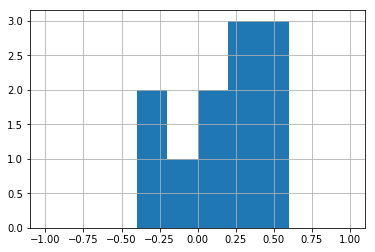

In [267]:
%matplotlib inline
df_opinion_sentence['polarity_score'].hist(range=[-1, 1])

In [ ]:
[print('*',i) for i in df_opinion_sentence.loc[df_opinion_sentence['polarity_score']>0.75,'opinion_sentence']];

In [ ]:
[print('*',i) for i in df_opinion_sentence.loc[df_opinion_sentence['polarity_score']<-0.1,'opinion_sentence']];

In [ ]:
df_opinion_sentence['subjective_score'].hist(range=[0, 1])

In [ ]:
a = TextBlob(df_review.loc[2,'review_clean'])

In [ ]:
obj = df_review.loc[4,'review_clean']
textblob_obj = TextBlob(obj)
textblob_obj.sentences[0].words

In [ ]:
textblob_obj.sentences[0].tags

In [ ]:
c = b[4].tags

In [ ]:
for idx,(word,tag) in enumerate(c):
    print(idx,word,tag)

In [ ]:
len(c)

In [ ]:
d = np.int_([])

In [ ]:
d

In [ ]:
d[0]

In [ ]:
d = np.append(d,[5])
d

In [ ]:
d = np.append(d,[3])
d

In [ ]:
d.min()

In [ ]:
d-7

In [ ]:
abs(d-7)

In [ ]:
for item in d:
    print(item)

In [ ]:
d

In [ ]:
c

In [ ]:
c[0][0]

In [ ]:
urlparse('https://media-cdn.tripadvisor.com/media/photo-s/02/15/17/ea/white-rock-lake-park.jpg')[0]

In [ ]:
'https://media-cdn.tripadvisor.com/media/photo-s/02/15/17/ea/white-rock-lake-park.jpg'.replace('photo-s','photo-w')

In [134]:
yelp_bussiness = pd.read_csv('/Users/ZhengLi/Downloads/yelp_business.csv')

In [136]:
yelp_bussiness.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [146]:
yelp_bussiness.loc[yelp_bussiness['state']=='IL','city'].unique()

array(['Urbana', 'Champaign', 'Savoy', 'Rantoul', 'Mahomet', 'Monticello',
       'Mansfield', 'Sidney', 'Tuscola', 'Saint Joseph', 'Ogden', 'Tolono',
       'Gifford', 'Philo', 'Oakwood', 'Elk Grove Villa', 'Homer',
       'St Joseph', 'Broadlands', 'Camargo', 'Fisher', 'Fithian', 'Royal',
       'Thomasboro', 'Villa Grove', 'Mohamet', 'Dewey'], dtype=object)